In [1]:
import requests
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import io
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [2]:
url = 'http://covidtracking.com/api/states/daily.csv'
s = requests.get(url).content


In [3]:


df = pd.read_csv(io.StringIO(s.decode('utf-8')))

df['date'] = pd.to_datetime(df['date'],format='%Y%m%d')

cols = ['date', 'state', 'positive', 'probableCases','negative','totalTestResultsSource','hospitalizedCurrently','hospitalizedCumulative','inIcuCurrently','onVentilatorCurrently','onVentilatorCumulative','recovered','dataQualityGrade','deathConfirmed','hospitalized','totalTestsViral','negativeTestsViral','positiveCasesViral','fips','totalTestsPeopleAntigen','positiveTestsPeopleAntigen']

df = df[df['date']<='2020-12-31']

df = df[cols]
df.set_index('date', inplace = True)
df['Day'] = df.index.day
df['Month'] = df.index.month
df['dayofweek'] = df.index.dayofweek



In [4]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,positive,probableCases,negative,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,onVentilatorCurrently,onVentilatorCumulative,recovered,deathConfirmed,hospitalized,totalTestsViral,negativeTestsViral,positiveCasesViral,fips,totalTestsPeopleAntigen,positiveTestsPeopleAntigen,Day,Month,dayofweek
positive,1.000000,0.870682,0.874609,0.711203,0.808253,0.648886,0.455192,0.845819,0.869039,0.724813,0.808253,0.929687,0.957928,0.998209,-0.147111,0.728766,0.911367,0.044048,0.447821,-0.004530
probableCases,0.870682,1.000000,0.620659,0.791610,0.697732,0.792567,0.446864,0.922507,0.848347,0.349142,0.697732,0.741017,0.832927,0.844527,-0.097878,0.338083,0.999801,0.073767,0.425515,-0.006805
negative,0.874609,0.620659,1.000000,0.586496,0.876188,0.435255,0.274076,0.899245,0.714671,0.736858,0.876188,0.940468,0.962879,0.855451,-0.196331,0.853137,0.726384,0.034876,0.499831,-0.004128
hospitalizedCurrently,0.711203,0.791610,0.586496,1.000000,0.527767,0.977246,0.903827,0.797222,0.567665,0.499738,0.527767,0.746852,0.727051,0.795638,-0.111934,0.401260,0.772175,0.022946,0.112026,-0.005281
hospitalizedCumulative,0.808253,0.697732,0.876188,0.527767,1.000000,0.407326,0.442001,0.917450,0.325632,0.813295,1.000000,0.875159,0.961697,0.920155,-0.074592,0.888986,0.920344,0.018850,0.267900,-0.001441
inIcuCurrently,0.648886,0.792567,0.435255,0.977246,0.407326,1.000000,0.966863,0.881126,0.548889,0.416482,0.407326,0.681396,0.615258,0.782744,-0.127692,0.313026,0.669172,0.017226,-0.022627,-0.002488
onVentilatorCurrently,0.455192,0.446864,0.274076,0.903827,0.442001,0.966863,1.000000,0.882203,0.363158,0.311434,0.442001,0.473976,0.431184,0.453851,-0.060105,0.177142,0.665964,0.012011,-0.075123,-0.004208
onVentilatorCumulative,0.845819,0.922507,0.899245,0.797222,0.917450,0.881126,0.882203,1.000000,0.796419,0.979837,0.917450,0.834597,0.781744,0.869219,-0.393852,0.801510,0.816296,0.058347,0.704154,-0.002722
recovered,0.869039,0.848347,0.714671,0.567665,0.325632,0.548889,0.363158,0.796419,1.000000,0.406338,0.325632,0.792601,0.809736,0.925345,0.064126,0.886299,0.940584,0.042395,0.376523,-0.004776
deathConfirmed,0.724813,0.349142,0.736858,0.499738,0.813295,0.416482,0.311434,0.979837,0.406338,1.000000,0.813295,0.745831,0.826906,0.687163,-0.155121,0.645660,0.982981,0.030442,0.282899,-0.001268


In [5]:
y = df[['state','deathConfirmed']]

In [6]:
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]



In [7]:
to_drop

['inIcuCurrently',
 'onVentilatorCurrently',
 'deathConfirmed',
 'hospitalized',
 'negativeTestsViral',
 'positiveCasesViral',
 'positiveTestsPeopleAntigen']

In [8]:
# Drop features 
df.drop(to_drop, axis=1, inplace=True)

In [9]:
set_state = {}
for group,frame in df.groupby('state'):
    set_state[group] = frame

In [10]:
set_state['AK'].describe()

,positive,probableCases,negative,hospitalizedCurrently,hospitalizedCumulative,onVentilatorCumulative,recovered,totalTestsViral,fips,totalTestsPeopleAntigen,Day,Month,dayofweek
count,290.000000,0.0,0.0,258.000000,298.000000,0.0,224.000000,3.010000e+02,301.0,0.0,301.000000,301.000000,301.000000
mean,9296.268966,NaN,NaN,55.689922,264.402685,NaN,2153.107143,3.599420e+05,2.0,NaN,16.016611,7.574751,3.000000
std,12832.426633,NaN,NaN,45.748475,279.449963,NaN,2429.841183,3.770593e+05,0.0,NaN,8.764496,2.843453,2.003331
min,3.000000,NaN,NaN,7.000000,1.000000,NaN,29.000000,8.000000e+00,2.0,NaN,1.000000,3.000000,0.000000
25%,428.250000,NaN,NaN,20.250000,49.000000,NaN,370.250000,3.704500e+04,2.0,NaN,9.000000,5.000000,1.000000
50%,3669.500000,NaN,NaN,41.000000,159.500000,NaN,826.500000,2.458070e+05,2.0,NaN,16.000000,8.000000,3.000000
75%,11398.250000,NaN,NaN,74.500000,381.500000,NaN,2496.250000,5.305000e+05,2.0,NaN,24.000000,10.000000,5.000000
max,45461.000000,NaN,NaN,166.000000,1023.000000,NaN,7165.000000,1.275750e+06,2.0,NaN,31.000000,12.000000,6.000000


In [220]:
df_aux = set_state['AK']

y1 = y[y['state']=='AK']

df_aux['deathConfirmed'] = y1['deathConfirmed']


df_aux = df_aux.loc[:,df_aux.nunique() >1 ]

df_aux = pd.get_dummies(df_aux, columns=df_aux.select_dtypes(include=['object']).columns)

df_aux = (df_aux.fillna(method = 'ffill')
                .fillna(method = 'bfill'))



X_test = df_aux[df_aux['Month'] == 11][[col for col in df_aux.columns if col != 'deathConfirmed']]
y_test = df_aux[df_aux['Month'] > 11]['deathConfirmed'][1:]

X_train = df_aux[df_aux['Month'] <= 11][[col for col in df_aux.columns if col != 'deathConfirmed']][30:]
y_train = df_aux[df_aux['Month'] <= 11]['deathConfirmed'][:-30]



In [209]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [46]:
# MLPRegressor?

In [210]:
from sklearn.neural_network import MLPRegressor
activations = ['tanh', 'relu']
alphas= [0.0001,0.001, 0.01, 0.1, 1.0, 10, 100]

scores = []

for thisactivation  in activations:
    for thisalpha in alphas:
        print('-'*100)
        print(thisactivation,thisactivation)
        mlpreg = MLPRegressor(hidden_layer_sizes = [5, 5, 5],
                                     activation = thisactivation,
                                     alpha = thisalpha,
                                     solver = 'lbfgs',
                                     max_iter=5000, 
                                     batch_size=7).fit(X_train_scaled,y_train)

        scores.append([thisactivation,thisalpha, mlpreg.score(X_train_scaled, y_train), mlpreg.score(X_test_scaled, y_test)])

        
df_result = pd.DataFrame(scores, columns = ['ACTIVATION','ALPHA', 'TRAIN_R2','TEST_R2'])
df_parameter = df_result.loc[df_result['TEST_R2'].idxmax()]

mlpreg = MLPRegressor(hidden_layer_sizes = [5, 5, 5],
                             activation = df_parameter.loc['ACTIVATION'],
                             alpha = df_parameter.loc['ALPHA'],
                             solver = 'lbfgs',
                             max_iter=5000,batch_size=7).fit(X_train_scaled,y_train)

----------------------------------------------------------------------------------------------------
tanh tanh
----------------------------------------------------------------------------------------------------
tanh tanh


C:\Users\bruno\anaconda3\envs\aulas\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


----------------------------------------------------------------------------------------------------
tanh tanh


C:\Users\bruno\anaconda3\envs\aulas\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


----------------------------------------------------------------------------------------------------
tanh tanh


C:\Users\bruno\anaconda3\envs\aulas\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


----------------------------------------------------------------------------------------------------
tanh tanh


C:\Users\bruno\anaconda3\envs\aulas\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


----------------------------------------------------------------------------------------------------
tanh tanh
----------------------------------------------------------------------------------------------------
tanh tanh
----------------------------------------------------------------------------------------------------
relu relu
----------------------------------------------------------------------------------------------------
relu relu
----------------------------------------------------------------------------------------------------
relu relu
----------------------------------------------------------------------------------------------------
relu relu
----------------------------------------------------------------------------------------------------
relu relu
----------------------------------------------------------------------------------------------------
relu relu
----------------------------------------------------------------------------------------------------
relu relu


In [234]:
df_parameter

ACTIVATION        relu
ALPHA               10
TRAIN_R2      0.997622
TEST_R2       0.927314
Name: 12, dtype: object

In [236]:
mlpreg.score(X_train_scaled,y_train)

0.9976926883781311

In [237]:
mlpreg.score(X_test_scaled,y_test)

0.8875849760687287

In [238]:
predicao = pd.Series(mlpreg.predict(X_test_scaled), index = y_test.index, name = 'PREDICT')

df_pred = pd.concat([predicao,y_test], axis=1)

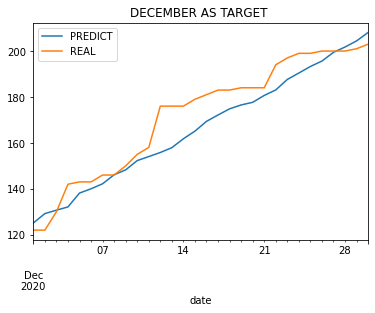

In [240]:


predicao = pd.Series(mlpreg.predict(X_test_scaled), index = y_test.index, name = 'PREDICT')
plt.title('DECEMBER AS TARGET ')
predicao.plot(label = 'PREDICT')
y_test.plot(label = 'REAL')
plt.legend()